In [1]:
import sys; sys.path.append('..')
import jittor as jt
import jittor.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import jittor.models as models
from utils import make_grid
from jittor import transform

jt.flags.use_cuda=True

[i 0706 14:56:48.410207 48 log.cc:351] Load log_sync: 1
[i 0706 14:56:48.490230 48 compiler.py:953] Jittor(1.3.4.15) src: /root/miniconda3/envs/jittor/lib/python3.7/site-packages/jittor
[i 0706 14:56:48.501627 48 compiler.py:954] g++ at /usr/bin/g++(7.5.0)
[i 0706 14:56:48.503093 48 compiler.py:955] cache_path: /root/.cache/jittor/jt1.3.4/g++7.5.0/py3.7.0/Linux-4.4.0-11x84/IntelRXeonRGolxda/default
[i 0706 14:56:48.513901 48 __init__.py:411] Found /usr/local/cuda/bin/nvcc(11.2.152) at /usr/local/cuda/bin/nvcc.
[i 0706 14:56:48.525789 48 __init__.py:411] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0706 14:56:48.898371 48 compiler.py:1008] cuda key:cu11.2.152_sm_75
[i 0706 14:56:49.181974 48 __init__.py:227] Total mem: 376.57GB, using 16 procs for compiling.
[i 0706 14:56:49.374274 48 jit_compiler.cc:28] Load cc_path: /usr/bin/g++
[i 0706 14:56:49.724225 48 init.cc:62] Found cuda archs: [75,]
[i 0706 14:56:50.564572 48 __init__.py:411] Found mpicc(2.1.1) at /usr/bin/mpicc.
[i 0706 14

In [2]:
class VGG16(nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super().__init__()
        vgg_jittor = models.vgg16(pretrained=pretrained)
        vgg_pretrained_features = vgg_jittor.features

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            self.eval() # jittor apply stop_grad to all param

    def execute(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        return h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3

vgg16 = VGG16()

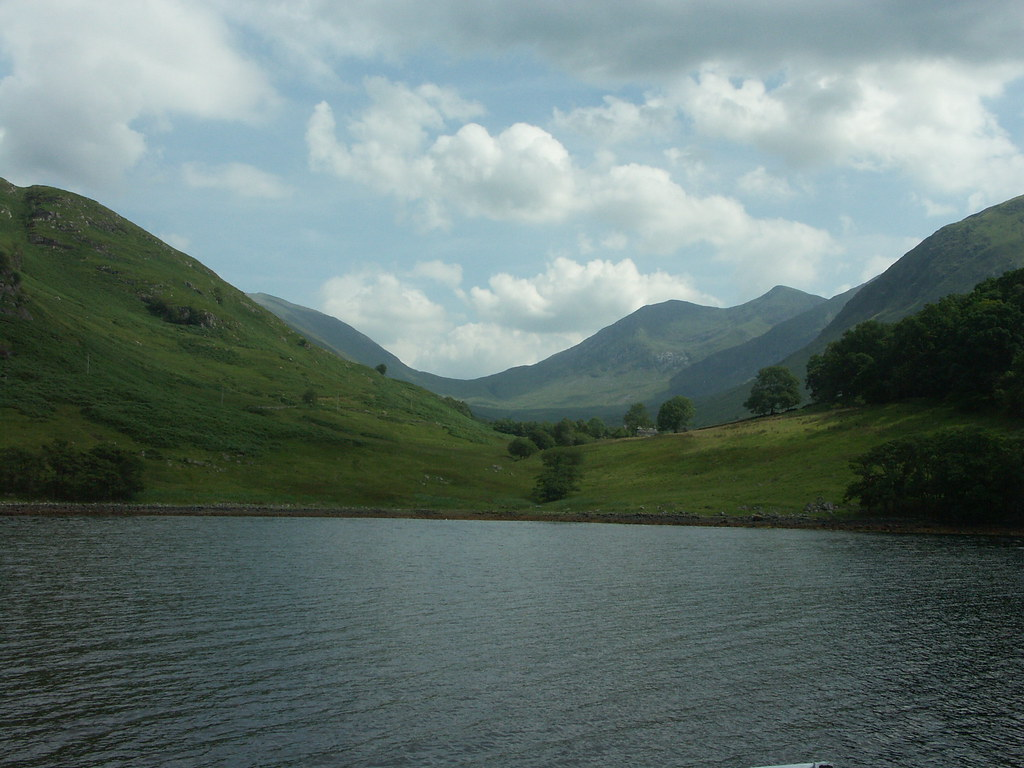

<class 'jittor.jittor_core.Var'> [1,3,768,1024,]
[1,64,768,1024,]
[1,128,384,512,]
[1,256,192,256,]
[1,512,96,128,]


In [10]:
image = Image.open('/nas/landscape/train_val/images/6737198563_602ccf89d5_b.jpg').convert('RGB')
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
trans = transform.Compose([
    # transform.Resize((384, 512)),
    transform.ToTensor(), 
    transform.ImageNormalize(mean=MEAN, std=STD),
])
image.show()
image = trans(image)[None, ...]
image = jt.array(image).stop_grad()
print(type(image), image.shape)
target_features = vgg16(image)
for t in target_features:
    print(t.shape)


In [11]:
def unnormalize(img: jt.Var):
    img = image.detach()
    mean = jt.array(MEAN).reshape(1, 3, 1, 1).stop_grad()
    std = jt.array(STD).reshape(1, 3, 1, 1).stop_grad()
    return (img * std) + mean

In [12]:
noise = jt.rand_like(image).start_grad()
optimizer = jt.optim.Adam([noise], lr=0.001)
imgs = [noise.detach()]
for i in range(1000):
    loss = nn.mse_loss(vgg16(noise)[3], target_features[3])
    optimizer.step(loss)
    if i % 100 == 0:
        print(loss.item())
        imgs.append(unnormalize(noise))

0.48341482877731323
0.22787843644618988
0.11338508874177933
0.0739087462425232
0.05509117618203163
0.04376189783215523
0.03611805662512779
0.030677534639835358
0.02668595127761364
0.023572195321321487
0.021111013367772102
0.019140038639307022
0.017520083114504814
0.01612820103764534
0.014940504916012287
0.013911683112382889
0.013025868684053421
0.012234271503984928
0.011529774405062199
0.0108979232609272


In [13]:
img_v = jt.contrib.concat(imgs, dim=0).data
print(img_v.shape, img_v.mean(), img_v.max(), img_v.min())
img_v = np.clip(img_v, -1, 1)
print(img_v.mean())

(21, 3, 768, 1024) 0.43798876 0.99999976 1.8146302e-09
0.43798876


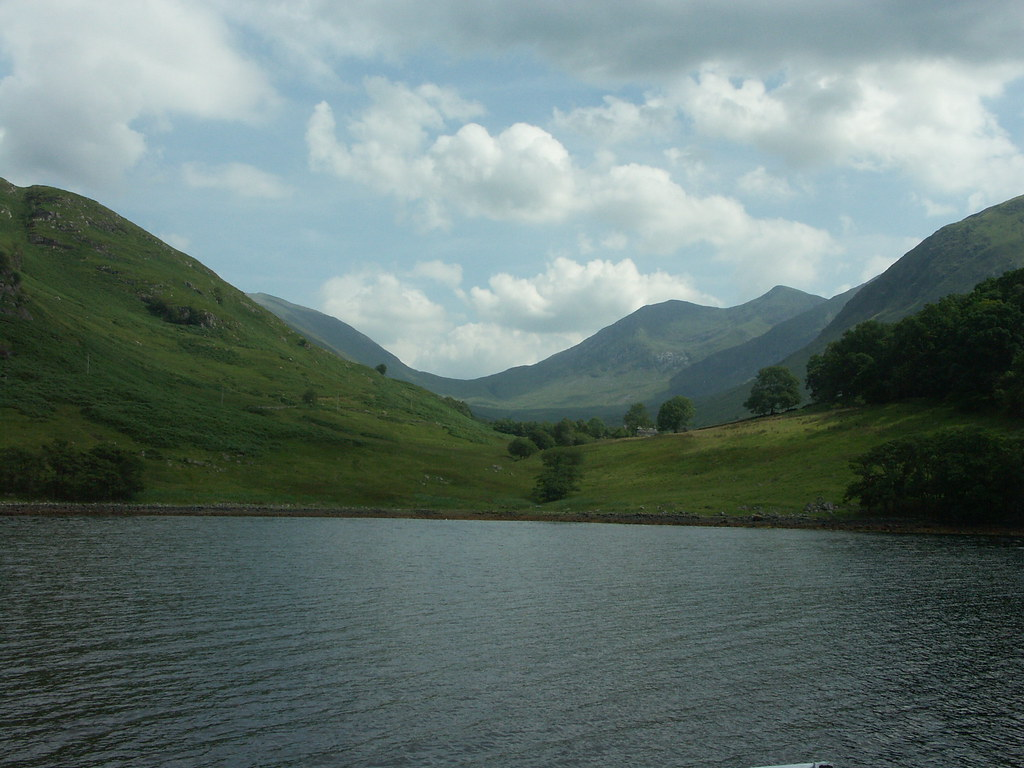

In [14]:
transform.to_pil_image(img_v[-1].transpose(1, 2, 0))

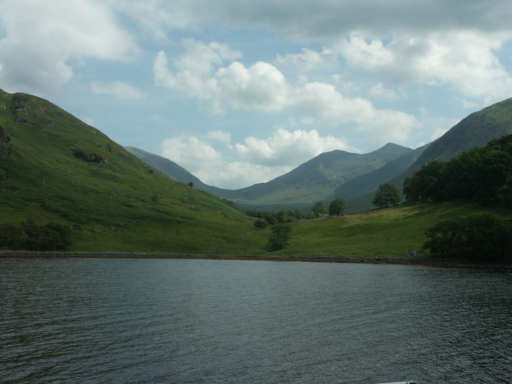

In [15]:
image = Image.open('/nas/landscape/train_val/images/6737198563_602ccf89d5_b.jpg').convert('RGB')
trans = transform.Compose([
    transform.Resize((384, 512)),
])
image = trans(image)
image.show()

warning! warning! pad 3 black images
(3072, 6144, 3)


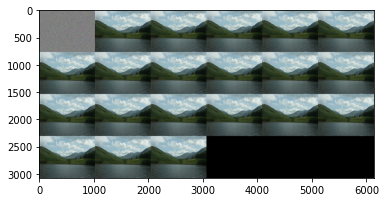

: 

In [16]:
img_grid = make_grid(img_v, 6)
print(img_grid.shape)
plt.imshow(img_grid)